# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D

import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [2]:
def plot_predictions(y_true, y_pred, shape, figsize):    
    f, ax = plt.subplots(2, y_true.shape[0], figsize=figsize)
    for i in range(y_true.shape[0]):
        ax[0][i].imshow(np.reshape(y_true[i], shape), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], shape), aspect='auto')
    plt.tight_layout()

In [3]:
def make_autoencoder(input_shape, layers, latent_dim, activation, activation_out):
    inputs = tf.keras.Input(shape=input_shape)

    encoder = tf.keras.layers.Dense(layers[0], activation=activation)(inputs)
    for layer in layers[1:]:
        encoder = tf.keras.layers.Dense(layer, activation=activation)(encoder)
    encoder = tf.keras.layers.Dense(latent_dim, activation=activation)(encoder)
    simple_encoder = tf.keras.Model(inputs=[inputs], outputs=[encoder])

    decoder_inputs = tf.keras.layers.Input(shape=[latent_dim])
    decoder = tf.keras.layers.Dense(layers[::-1][0], activation=activation)(decoder_inputs)
    for layer in layers[::-1][1:]:
        decoder = tf.keras.layers.Dense(layer, activation=activation)(decoder)

    outputs = tf.keras.layers.Dense(input_shape[0], activation=activation_out)(decoder)
    simple_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

    latent = simple_encoder(inputs)
    reconstructions = simple_decoder(latent)
    model = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])
    return model, simple_encoder

In [4]:
class sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

In [5]:
def make_VAE(input_shape, layers, latent_dim, activation, activation_out):
    inputs = tf.keras.Input(shape=input_shape)
    encoder = tf.keras.layers.Dense(layers[0], activation=activation)(inputs)
    for layer in layers[1:]:
        encoder = tf.keras.layers.Dense(layer, activation=activation)(encoder)

    latent_mean = tf.keras.layers.Dense(latent_dim)(encoder) #Mean Encoding 
    latent_log_var = tf.keras.layers.Dense(latent_dim)(encoder) #LogVar Encoding
    latent_space = sampling()([latent_mean, latent_log_var])
    variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[latent_mean, latent_log_var, latent_space])

    decoder_inputs = tf.keras.layers.Input(shape=[latent_dim])
    decoder = tf.keras.layers.Dense(layers[::-1][0], activation=activation)(decoder_inputs)
    for layer in layers[::-1][1:]:
        decoder = tf.keras.layers.Dense(layer, activation=activation)(decoder)

    outputs = tf.keras.layers.Dense(input_shape[0], activation=activation_out)(decoder)
    variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

    _, _, latent = variational_encoder(inputs)
    reconstructions = variational_decoder(latent)
    model = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

    latent_loss = -0.5 *K.sum(1 + latent_log_var - K.exp(latent_log_var) - K.square(latent_mean), axis=-1)
    vae_loss = K.mean(latent_loss)/np.prod(input_shape)
    model.add_loss(vae_loss)
    return model, variational_decoder

In [6]:
def plot_generated_samples(mat):
    n = mat.shape[0]
    fig, axes = plt.subplots(1, n, figsize = (20, 10))
    for image, ax in zip(mat, axes):
        ax.imshow(image)

In [7]:
def visualize_clean_vs_noisy(x, x_noise, num_images=5):
    plt.figure(figsize=(15, 5))  
    
    for i in range(num_images):
        index = np.random.randint(0, x.shape[0])

        # Display the clean image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x[index])
        plt.title("Clean Image")
        plt.axis('off')  

        # Display the corresponding noisy image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(x_noise[index])
        plt.title("Noisy Image")
        plt.axis('off')  

    plt.tight_layout()  
    plt.show()

In [8]:
def make_conv_DAE(input_shape, layers, kernel_size, pooling_size, activation, activation_out, output):
    encoder_input = tf.keras.Input(shape=input_shape)
    x = Conv2D(layers[0], kernel_size, activation=activation, padding='same')(encoder_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pooling_size, padding='same')(x) 
    for layer in layers[1:]:
        x = Conv2D(layer, kernel_size, activation=activation, padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pooling_size, padding='same')(x) 
    
    for layer in layers[::-1]:
        x = Conv2D(layer, kernel_size, activation=activation, padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D()(x)
    decoded = Conv2D(output, kernel_size, activation=activation_out, padding='same')(x)
    model = tf.keras.Model(encoder_input, decoded)
    return model

In [9]:
def visualize_original_noise_reconstructed(autoencoder, x, x_noise, num_images=5):
    reconstructed_images = autoencoder.predict(x_noise)
    
    plt.figure(figsize=(25, 10)) 

    for i in range(num_images):
        #original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(x[i])
        plt.title("Original")
        plt.axis('off')

        # noisy image
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(x_noise[i])
        plt.title("Noisy")
        plt.axis('off') 

        #  reconstructed image
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis('off')  

    plt.tight_layout()  
    plt.show()

# Prepare data

In [10]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255., x_test / 255.
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
x_train = x_train.astype(np.float32, copy=False)
x_test = x_test.astype(np.float32, copy=False)

# Simple Autoencoder (AE)

In [12]:
model, encoder = make_autoencoder((784,), [512,128,32,8], 2, 'selu', 'sigmoid')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

## Train

In [13]:
history = model.fit(x=x_train, y=x_train, validation_split=0.2, batch_size=2048, epochs=1000, callbacks=[reduce_lr, early_stopping])

Epoch 1/1000
24/24 [==============================] - 2s 16ms/step - loss: 0.1557 - val_loss: 0.1272 - lr: 1.0000e-04
Epoch 2/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.1058 - val_loss: 0.0890 - lr: 1.0000e-04
Epoch 3/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0818 - val_loss: 0.0755 - lr: 1.0000e-04
Epoch 4/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0710 - val_loss: 0.0667 - lr: 1.0000e-04
Epoch 5/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.0601 - lr: 1.0000e-04
Epoch 6/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0576 - val_loss: 0.0550 - lr: 1.0000e-04
Epoch 7/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0530 - val_loss: 0.0508 - lr: 1.0000e-04
Epoch 8/1000
24/24 [==============================] - 0s 9ms/step - loss: 0.0493 - val_loss: 0.0478 - lr: 1.0000e-04
Epoch 9/1000
24/24 [==============================] - 0s 9ms/st

## History

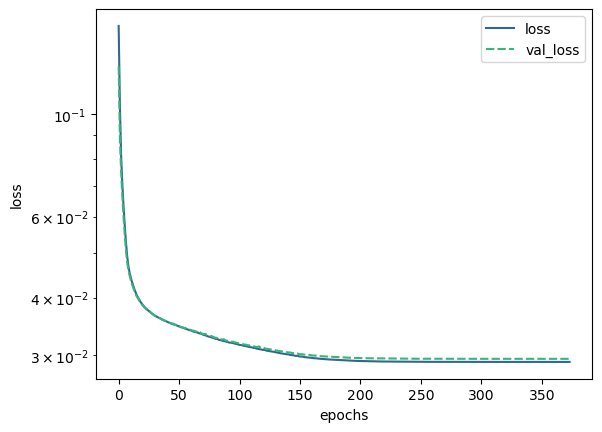

In [14]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(data=hist, palette='viridis')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')

## Show results

1/1 [==============================] - 0s 81ms/step


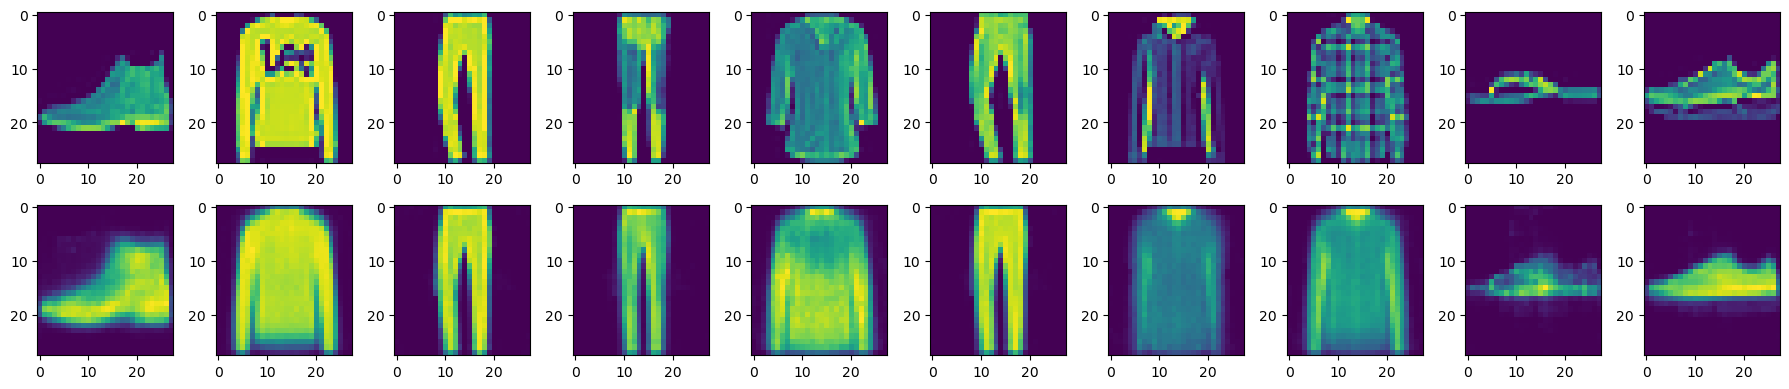

In [15]:
y_true = x_test[:10]
y_pred = model.predict(y_true)
plot_predictions(y_true, y_pred, (28,28), (18,4))

## Dimensionality reduction comparison

<Axes: >

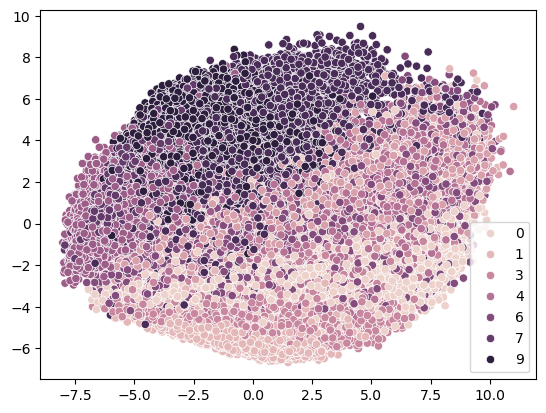

In [16]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train)

sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=y_train)

1875/1875 [==============================] - 2s 952us/step


<Axes: >

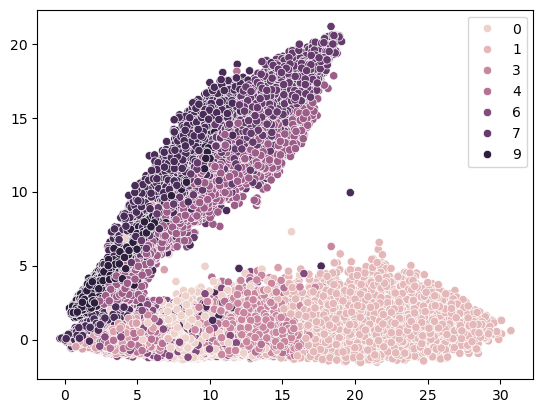

In [17]:
x_latent = encoder.predict(x_train)
sns.scatterplot(x=x_latent[:,0], y=x_latent[:,1], hue=y_train)

# Variational Autoencoders (VAE)

In [18]:
latent_dim = 128
model, variational_decoder = make_VAE((784,), [512,256], latent_dim, 'gelu', 'sigmoid')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

## Train

In [19]:
history = model.fit(x_train, x_train, epochs=1000, batch_size=2048, validation_data=(x_test, x_test), callbacks=[reduce_lr, early_stopping])

Epoch 1/1000
30/30 [==============================] - 1s 20ms/step - loss: 0.1047 - val_loss: 0.0759 - lr: 0.0010
Epoch 2/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.0645 - val_loss: 0.0582 - lr: 0.0010
Epoch 3/1000
30/30 [==============================] - 0s 12ms/step - loss: 0.0563 - val_loss: 0.0545 - lr: 0.0010
Epoch 4/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.0533 - val_loss: 0.0516 - lr: 0.0010
Epoch 5/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.0505 - val_loss: 0.0490 - lr: 0.0010
Epoch 6/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.0478 - val_loss: 0.0462 - lr: 0.0010
Epoch 7/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.0452 - val_loss: 0.0437 - lr: 0.0010
Epoch 8/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.0428 - val_loss: 0.0419 - lr: 0.0010
Epoch 9/1000
30/30 [==============================] - 0s 11ms/step - loss: 0.0412 - val_

## History

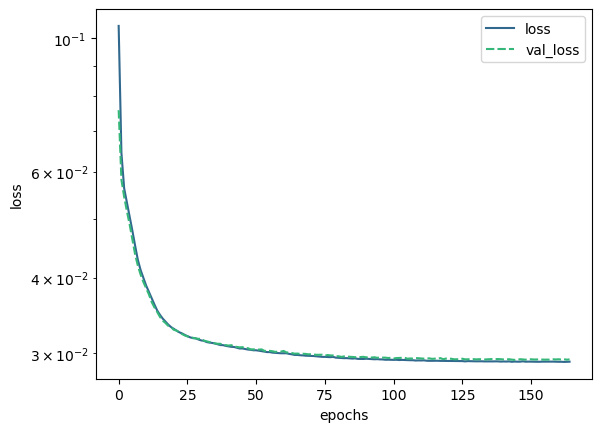

In [20]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(data=hist, palette='viridis')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')

## Generate samples

1/1 [==============================] - 0s 18ms/step


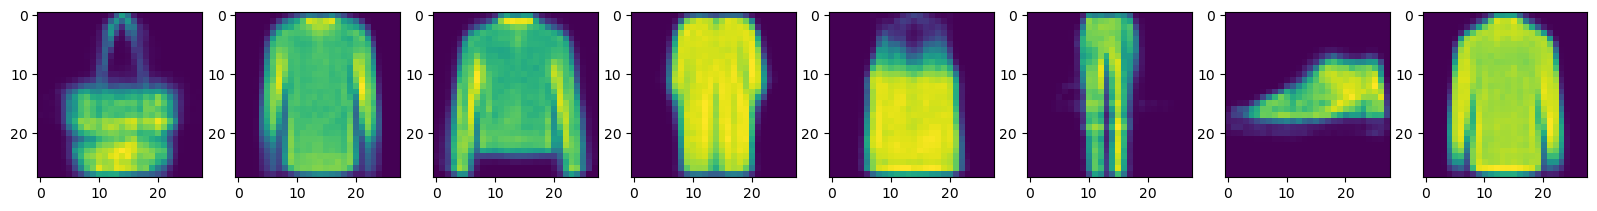

In [24]:
n_sample = 8
latent_space = tf.random.normal(shape = [n_sample, latent_dim])
images = variational_decoder.predict(latent_space).reshape(n_sample,28,28)        
plot_generated_samples(images)

# Denoising Autoencoder (DAE)

## Prepare and add noise on data

In [25]:
x_train = x_train.reshape((x_train.shape[0], 28,28,1))
x_test = x_test.reshape((x_test.shape[0], 28,28,1))

In [26]:
noise_factor = 0.1

x_train_noise = x_train + np.random.normal(0, noise_factor, (x_train.shape[0], 28,28,1))
x_test_noise = x_test + np.random.normal(0, noise_factor, (x_test.shape[0],28,28,1))

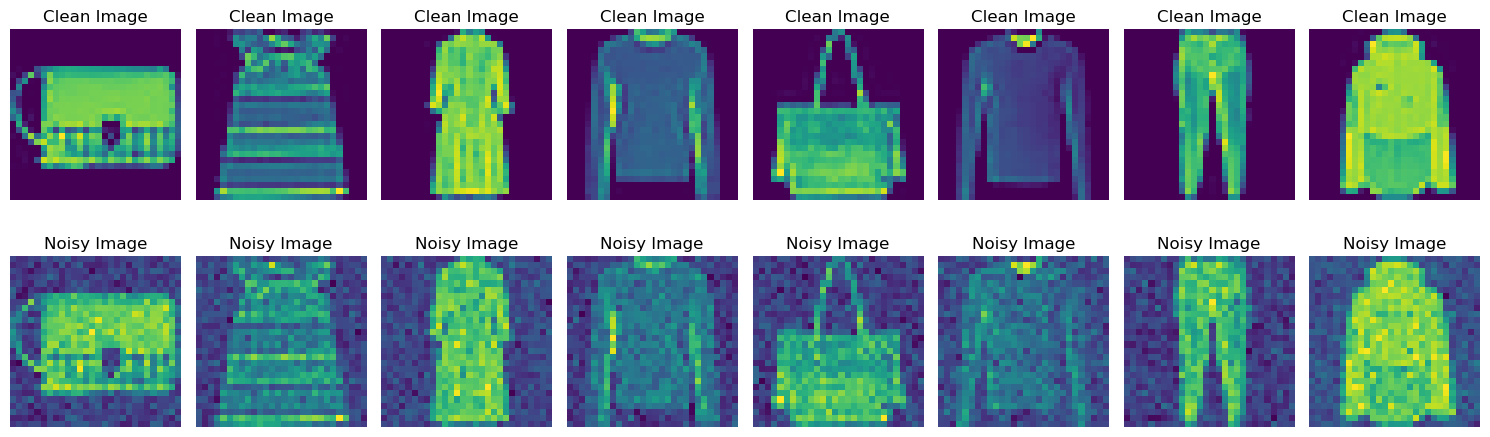

In [27]:
visualize_clean_vs_noisy(x_train, x_train_noise, num_images=8)

## Make model

In [34]:
model = make_conv_DAE(input_shape=(28,28,1), layers=[64,32], kernel_size=(3,3), pooling_size=(2,2), 
                        activation='selu', activation_out='sigmoid', output=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

## Train

In [35]:
history = model.fit(x_train_noise, x_train, batch_size=2048, epochs=1000, 
                    validation_data=(x_test_noise, x_test), callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/1000
30/30 [==============================] - 6s 152ms/step - loss: 0.0608 - val_loss: 0.0727 - lr: 0.0010
Epoch 2/1000
30/30 [==============================] - 4s 134ms/step - loss: 0.0311 - val_loss: 0.0389 - lr: 0.0010
Epoch 3/1000
30/30 [==============================] - 4s 134ms/step - loss: 0.0244 - val_loss: 0.0437 - lr: 0.0010
Epoch 4/1000
30/30 [==============================] - 4s 138ms/step - loss: 0.0201 - val_loss: 0.0480 - lr: 0.0010
Epoch 5/1000
30/30 [==============================] - 4s 140ms/step - loss: 0.0172 - val_loss: 0.0504 - lr: 0.0010
Epoch 6/1000
30/30 [==============================] - 4s 148ms/step - loss: 0.0150 - val_loss: 0.0595 - lr: 0.0010
Epoch 7/1000
30/30 [==============================] - 4s 146ms/step - loss: 0.0136 - val_loss: 0.0624 - lr: 0.0010
Epoch 8/1000
30/30 [==============================] - 4s 148ms/step - loss: 0.0125 - val_loss: 0.0678 - lr: 8.0000e-04
Epoch 9/1000
30/30 [==============================] - 4s 140ms/step - loss: 

## History

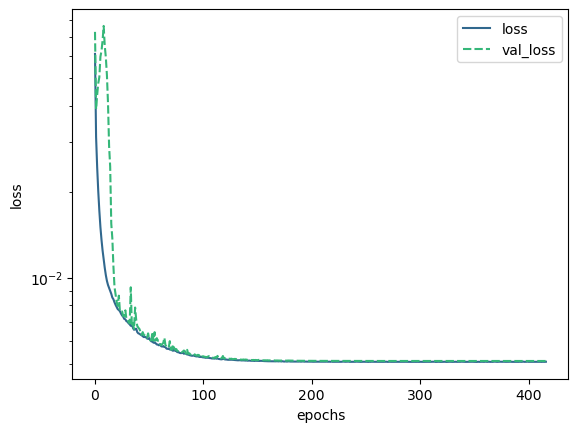

In [36]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(data=hist, palette='viridis')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')

## Show results

313/313 [==============================] - 1s 2ms/step


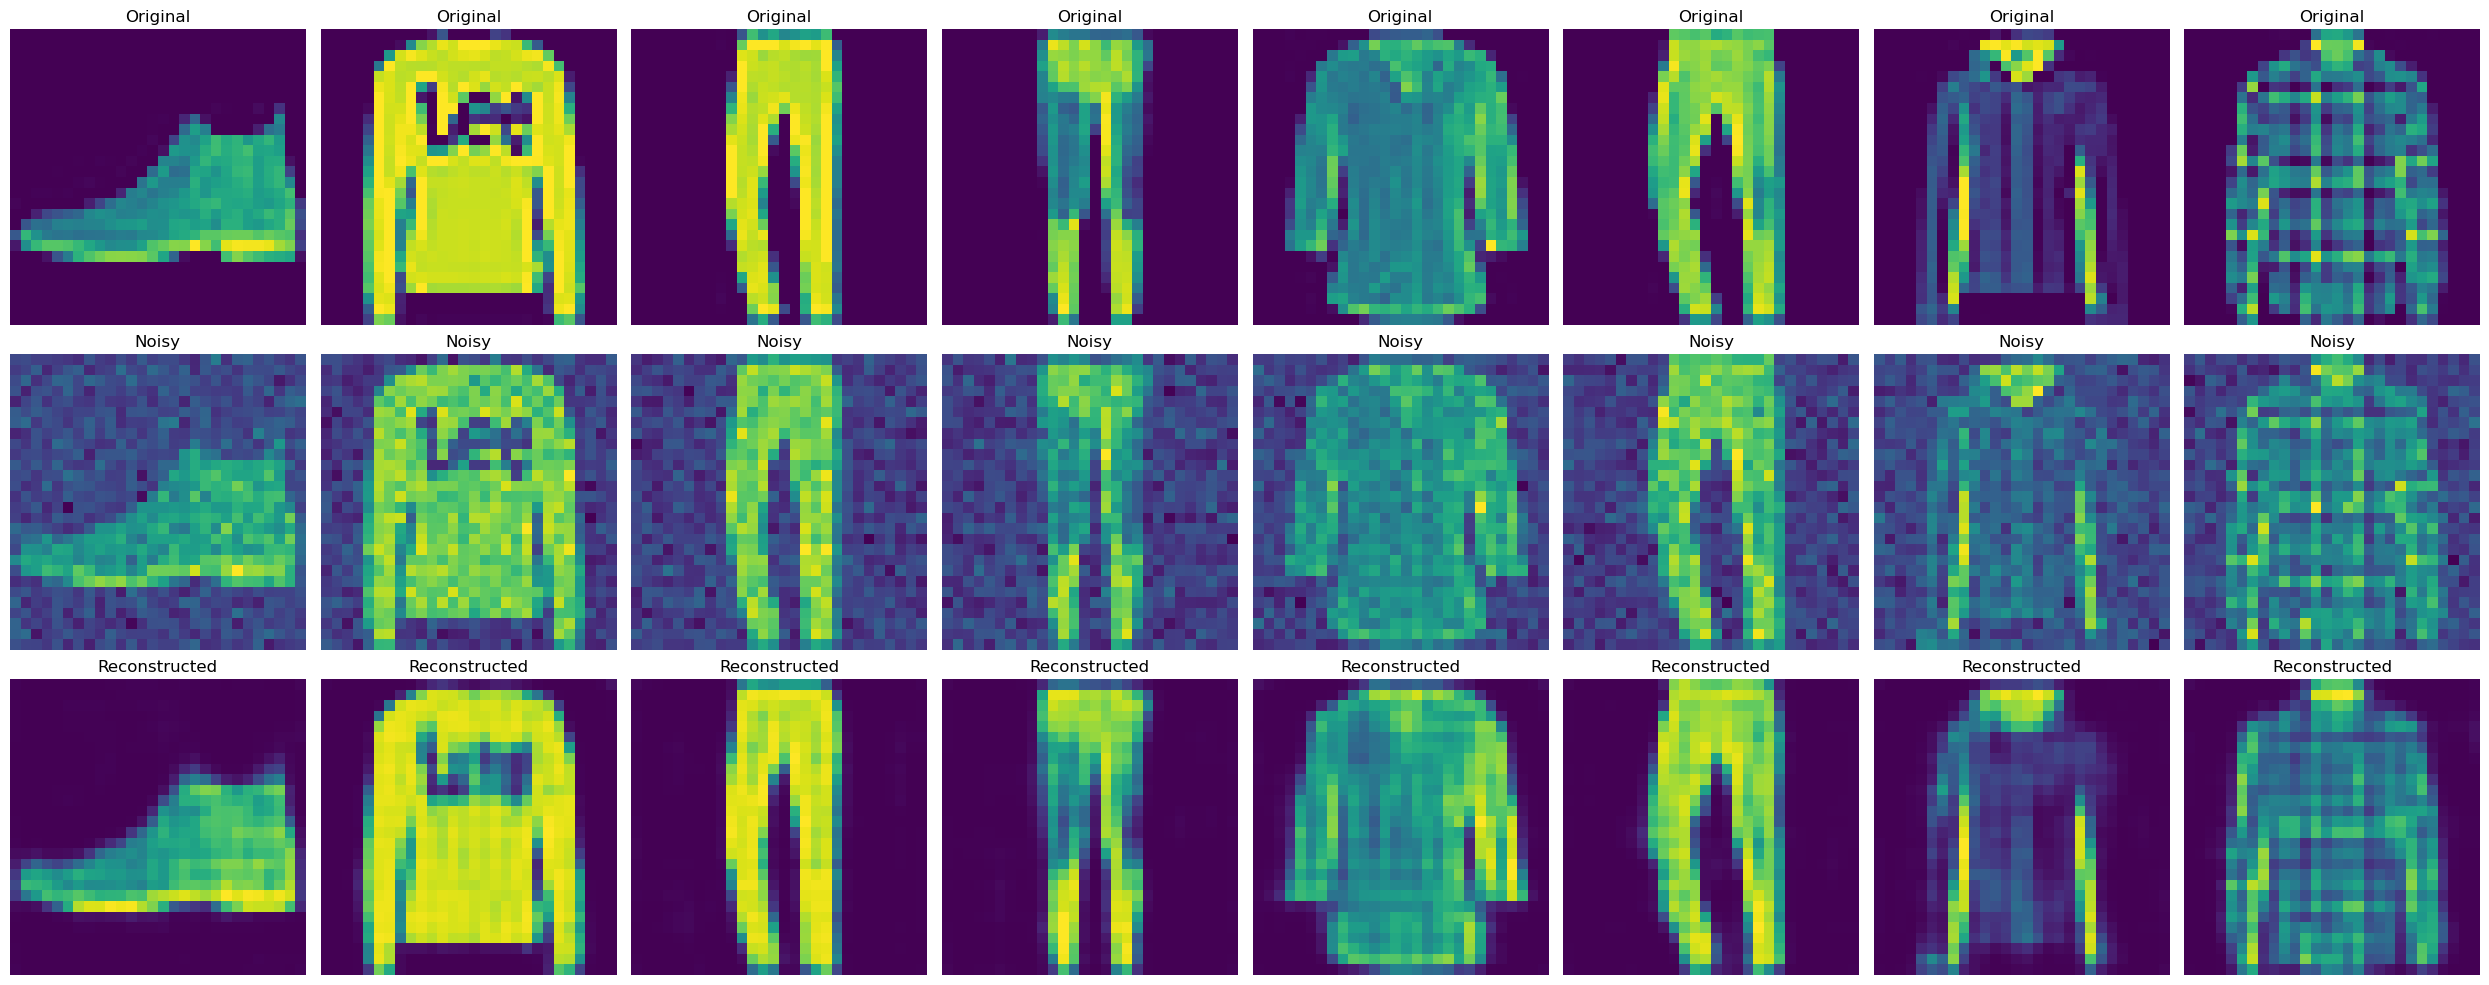

In [37]:
visualize_original_noise_reconstructed(model, x_test, x_test_noise, num_images=8)